This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

In [143]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# we are working with PBMCs so lets store some marker genes
marker_genes = ['CD14', 'LYZ', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'GNLY', 'NKG7',
                'MS4A1', 'IL7R', 'CCR7', 'S100A4', 'CD8A', 'PPBP']

marker_genes_dict = {
    'CD14 Mono': ['CD14', 'LYZ'],
    'CD16 Mono': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'NK': ['GNLY', 'NKG7'],
    'B Cell': ['MS4A1', 'CD79A'],
    'CD4 T': ['IL7R'],
    'CD4 T Naive': ['CCR7'],
    'CD4 T Memory': ['S100A4'],
    'CD8 T': ['CD8A'],
    'Megakaryocytes': ['PPBP']
}

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B cell)'],
    'CD79A': ['CD79A (B cell)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}



scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [144]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/pbmc6k/hg19/"

results_file = f"{data_path}/pbmc6k.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc6k-..-..-data-single_cell_data-pbmc6k-hg19-matrix.h5ad


In [145]:
# make cell type specific marker annotation


# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

## Preprocessing

In [146]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 5419 × 32738
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


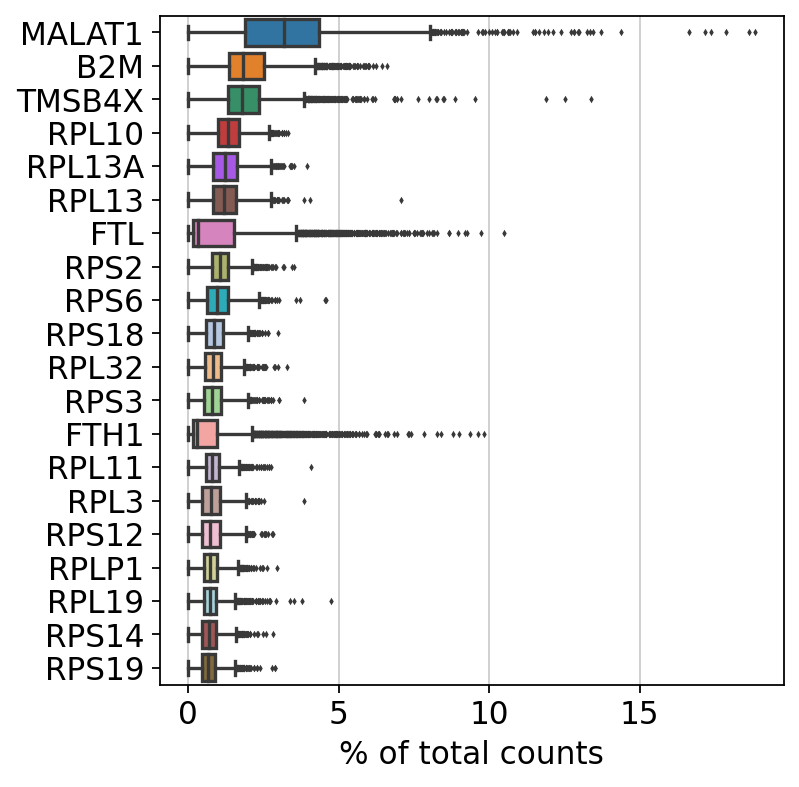

In [147]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [148]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)


filtered out 673 cells that have less than 500 genes expressed
filtered out 19601 genes that are detected in less than 5 cells


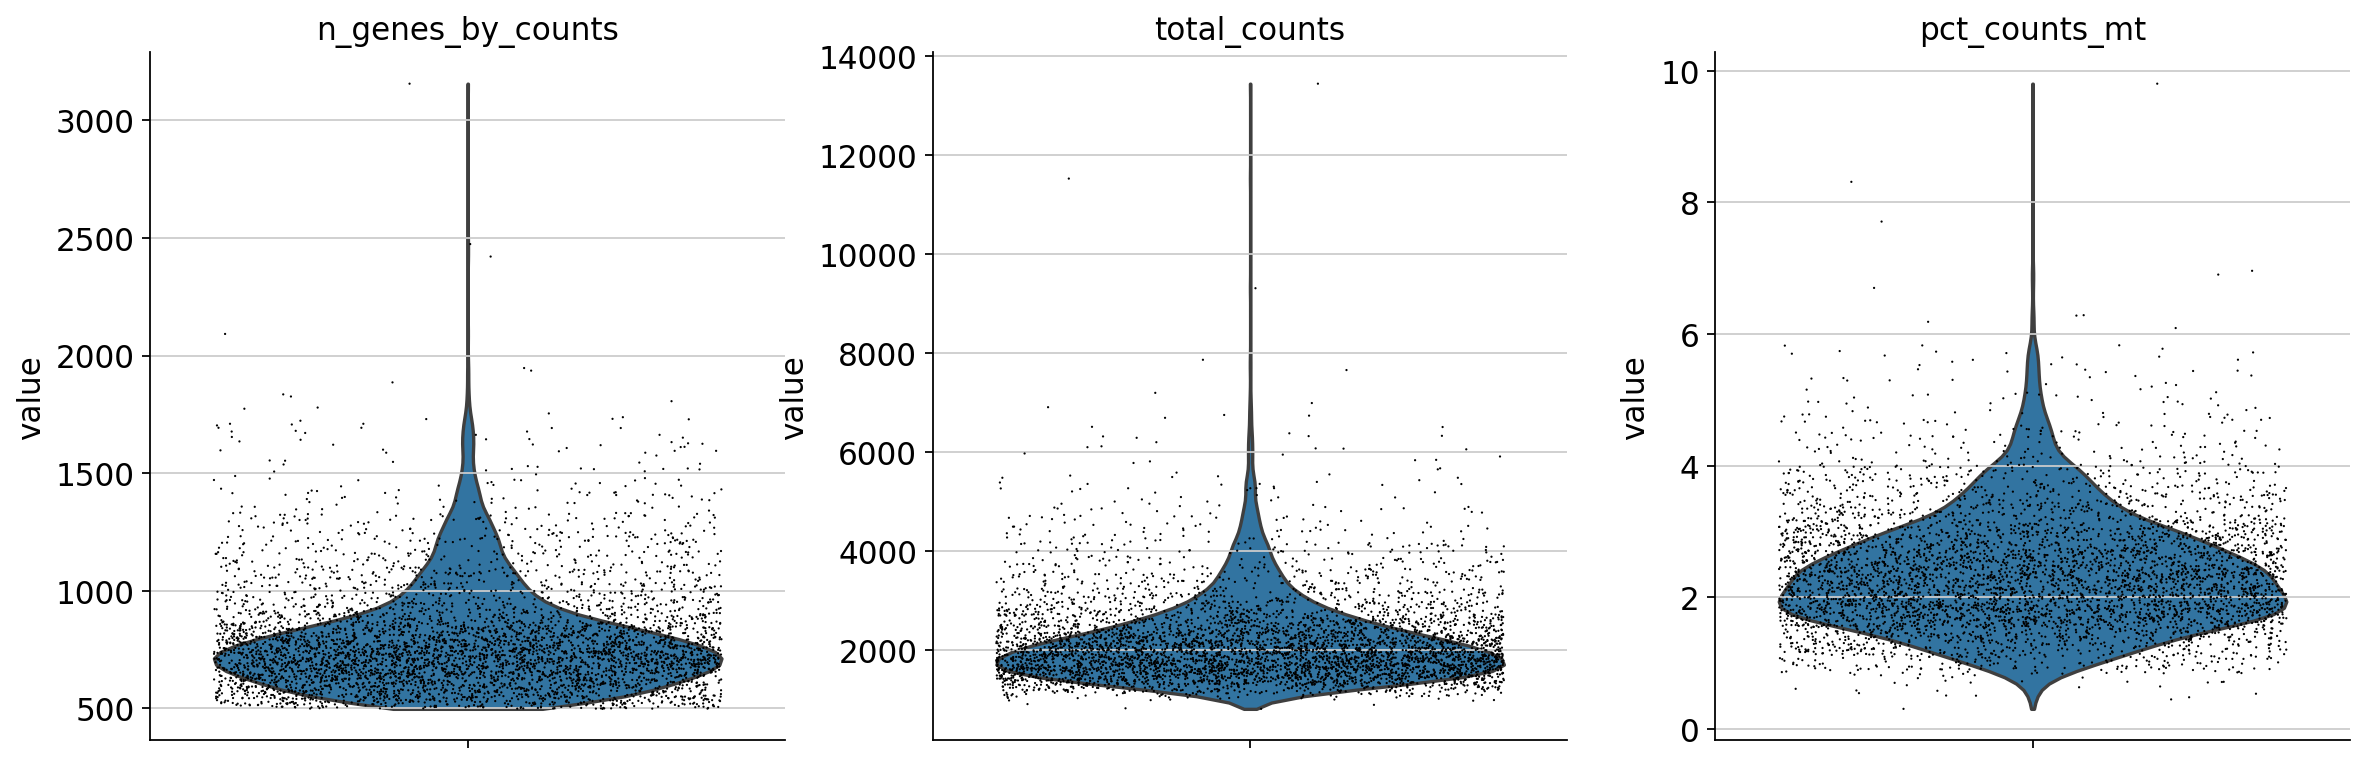

In [149]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

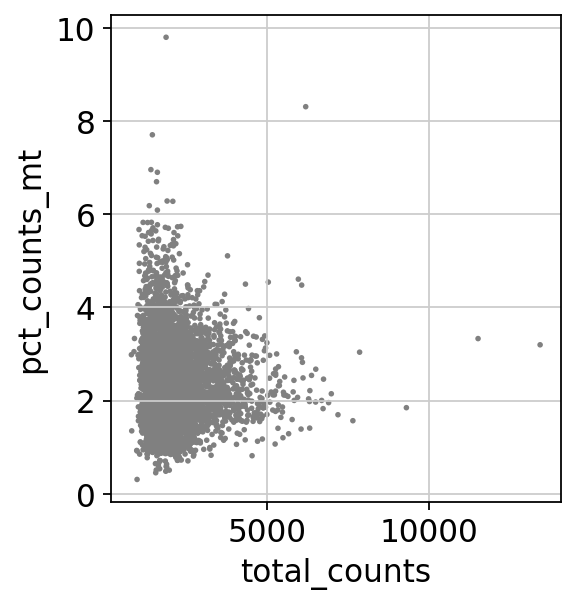

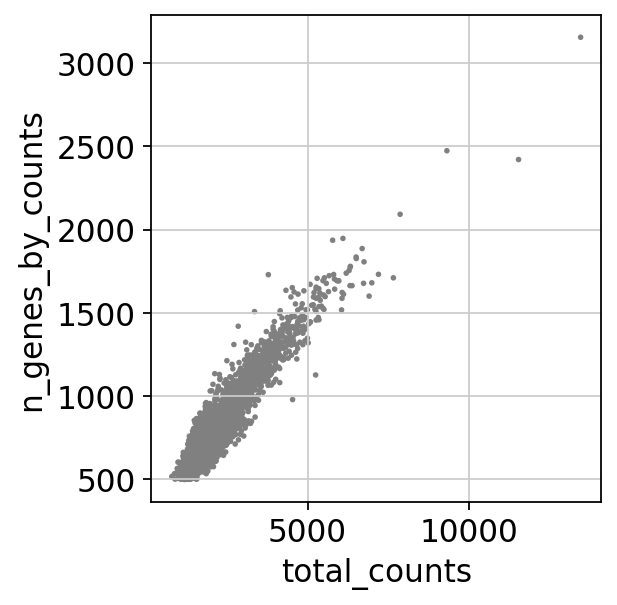

In [150]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [151]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


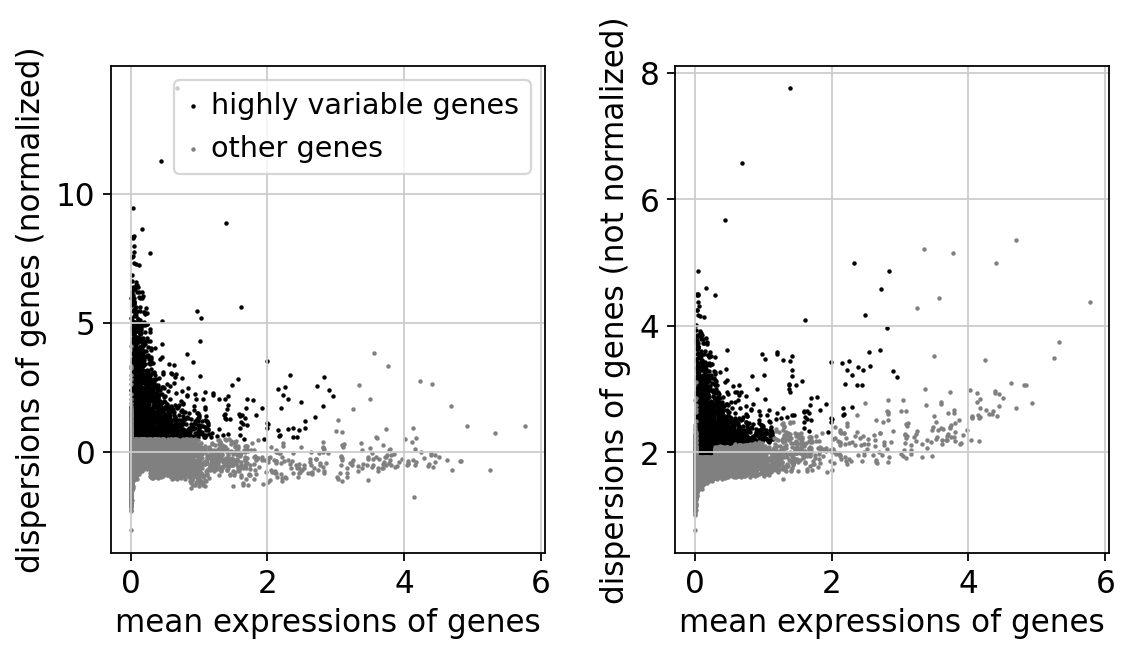

In [152]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)


In [153]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:18)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


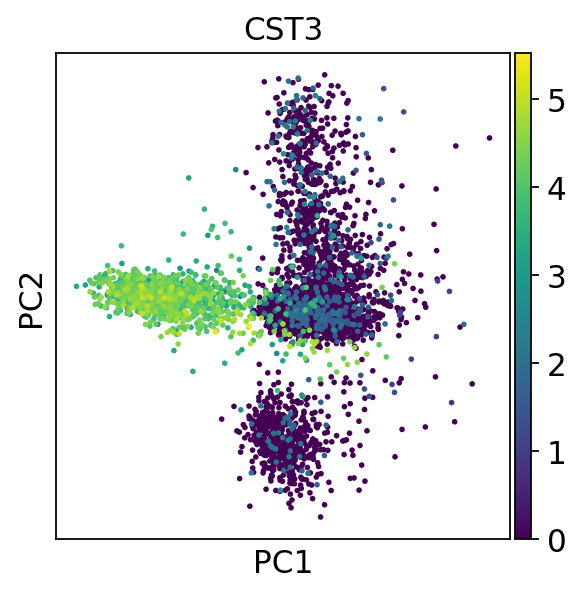

In [154]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color='CST3')


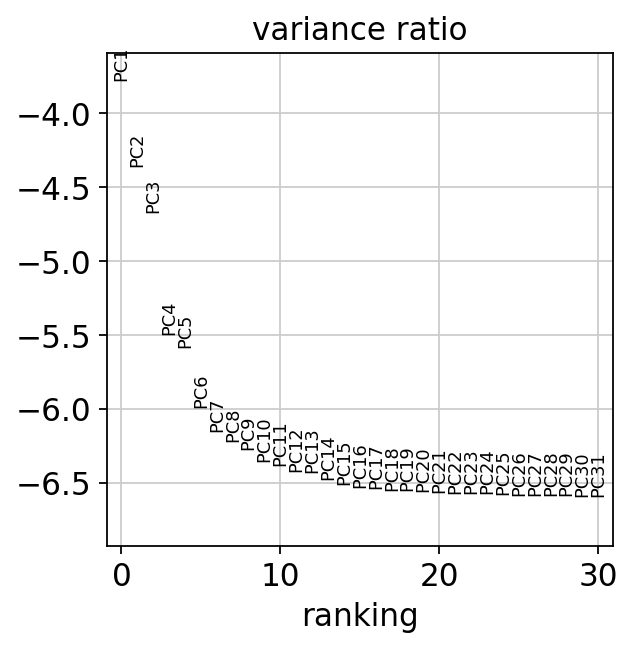

In [155]:
sc.pl.pca_variance_ratio(adata, log=True)


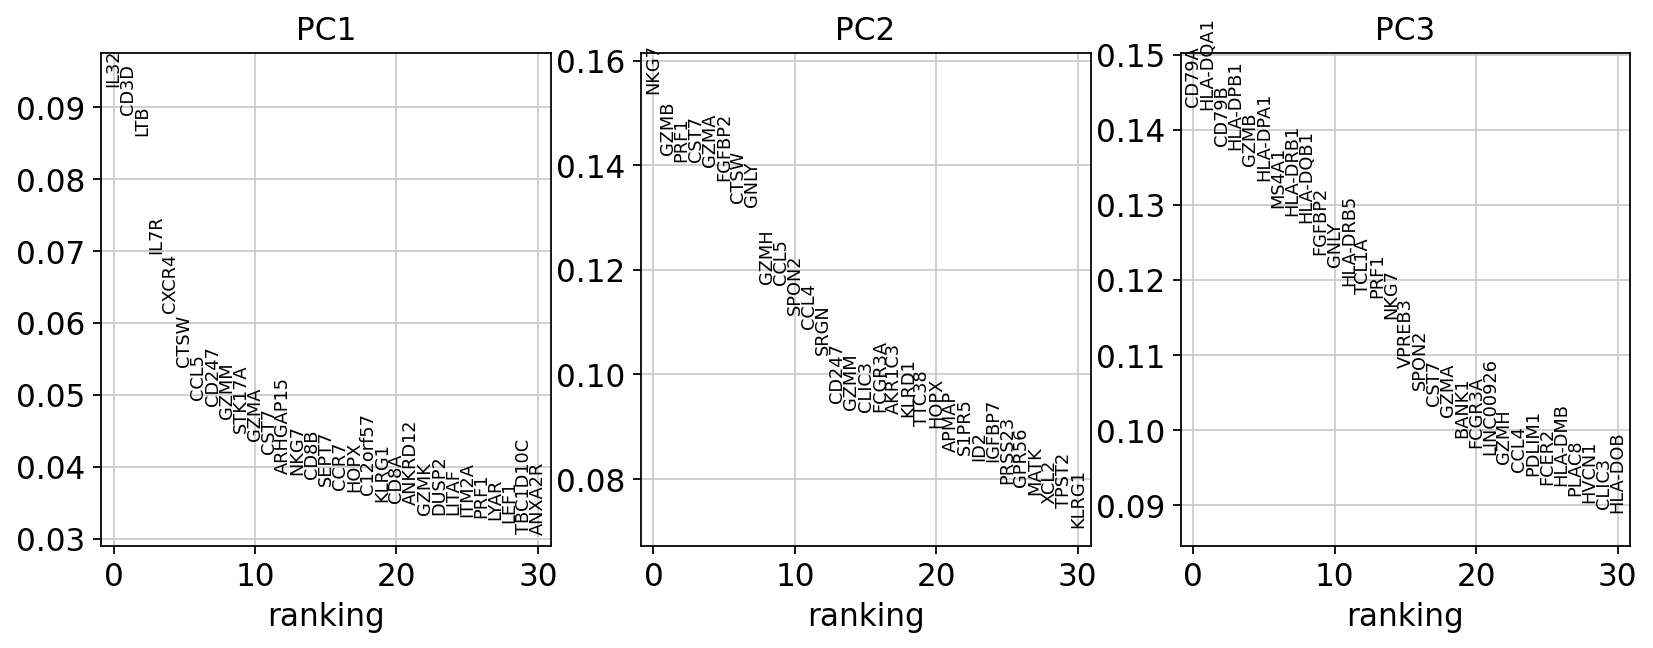

In [156]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [157]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [158]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


## Cluster the neighborhood graph

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


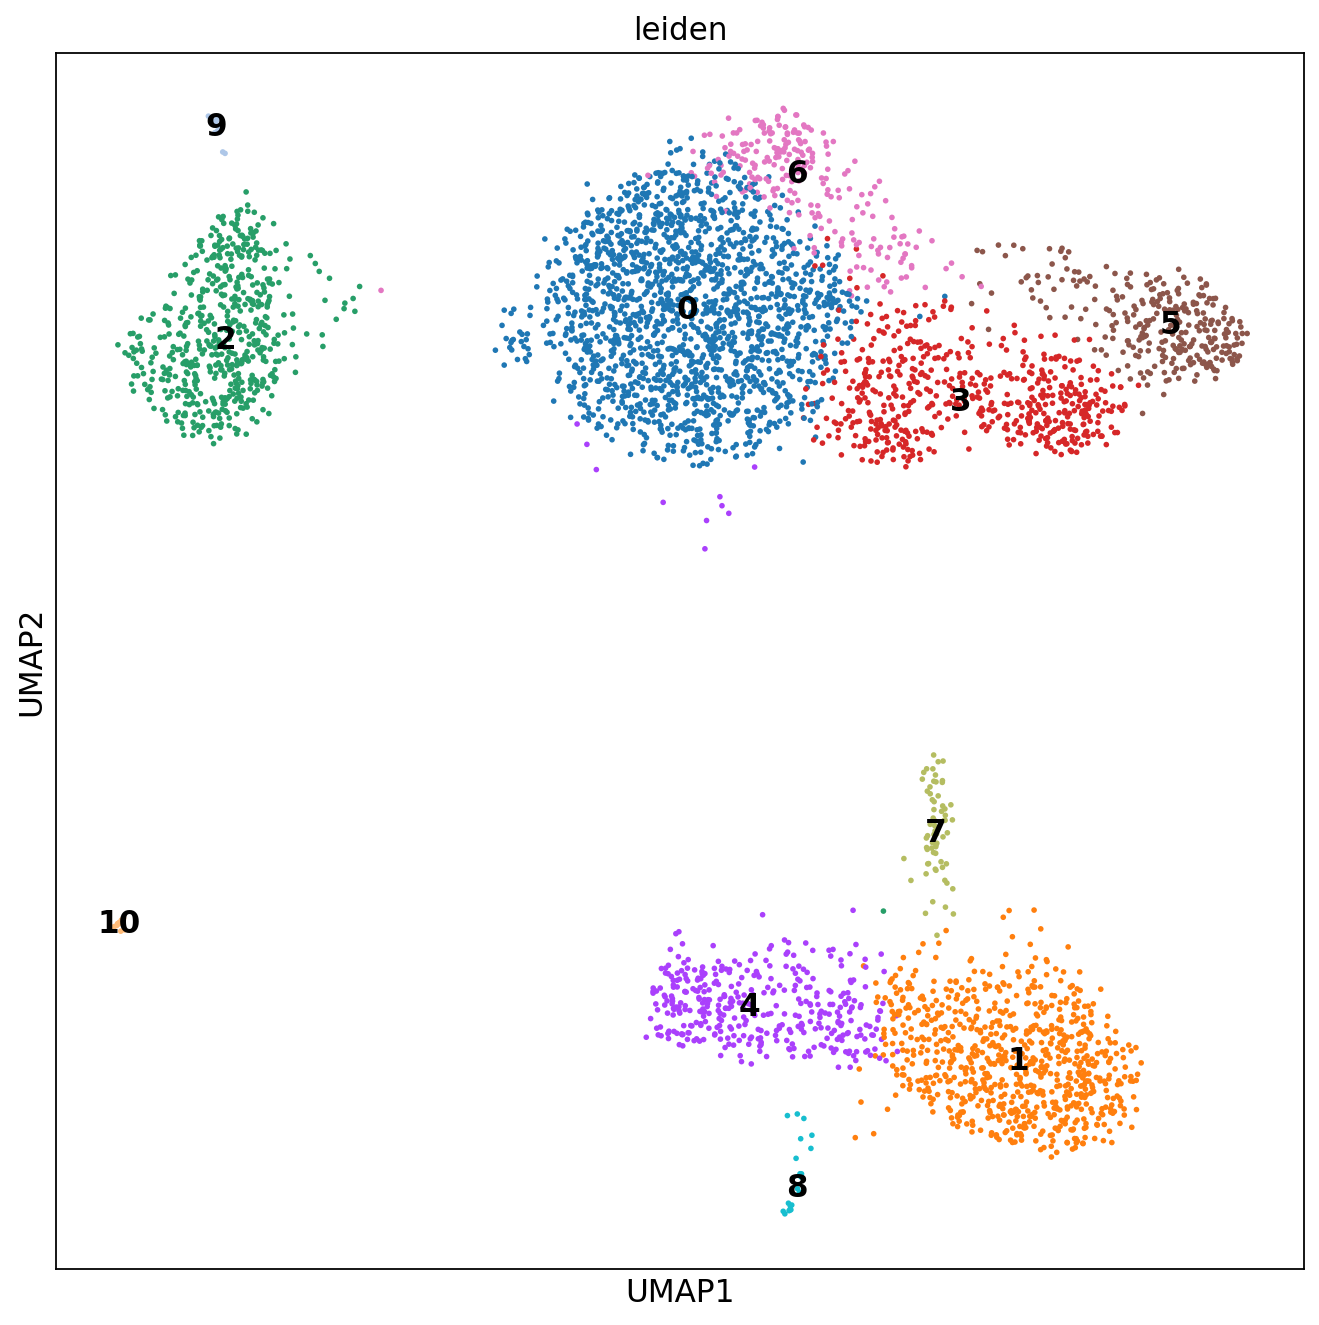

In [159]:
# lets use Leiden clustering
sc.tl.leiden(adata, resolution=0.7)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

# save
adata.write(results_file)


In [170]:
# make merged cell type predictions
cell_dict = {'Cytotoxic T cell': ['3'], 'CD16+ monocyte': ['4'], 'CD14+ monocyte': ['1'], 'CD4+ T cell': ['0'],
    'B cell': ['2'], 'Natural killer cell': ['5'], 'Dendritic cell': ['7'], 'Megakaryocyte': ['8']}


# Initialize empty column in cell metadata
adata.obs['merged'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'merged'] = i


running Leiden clustering
    finished (0:00:00)


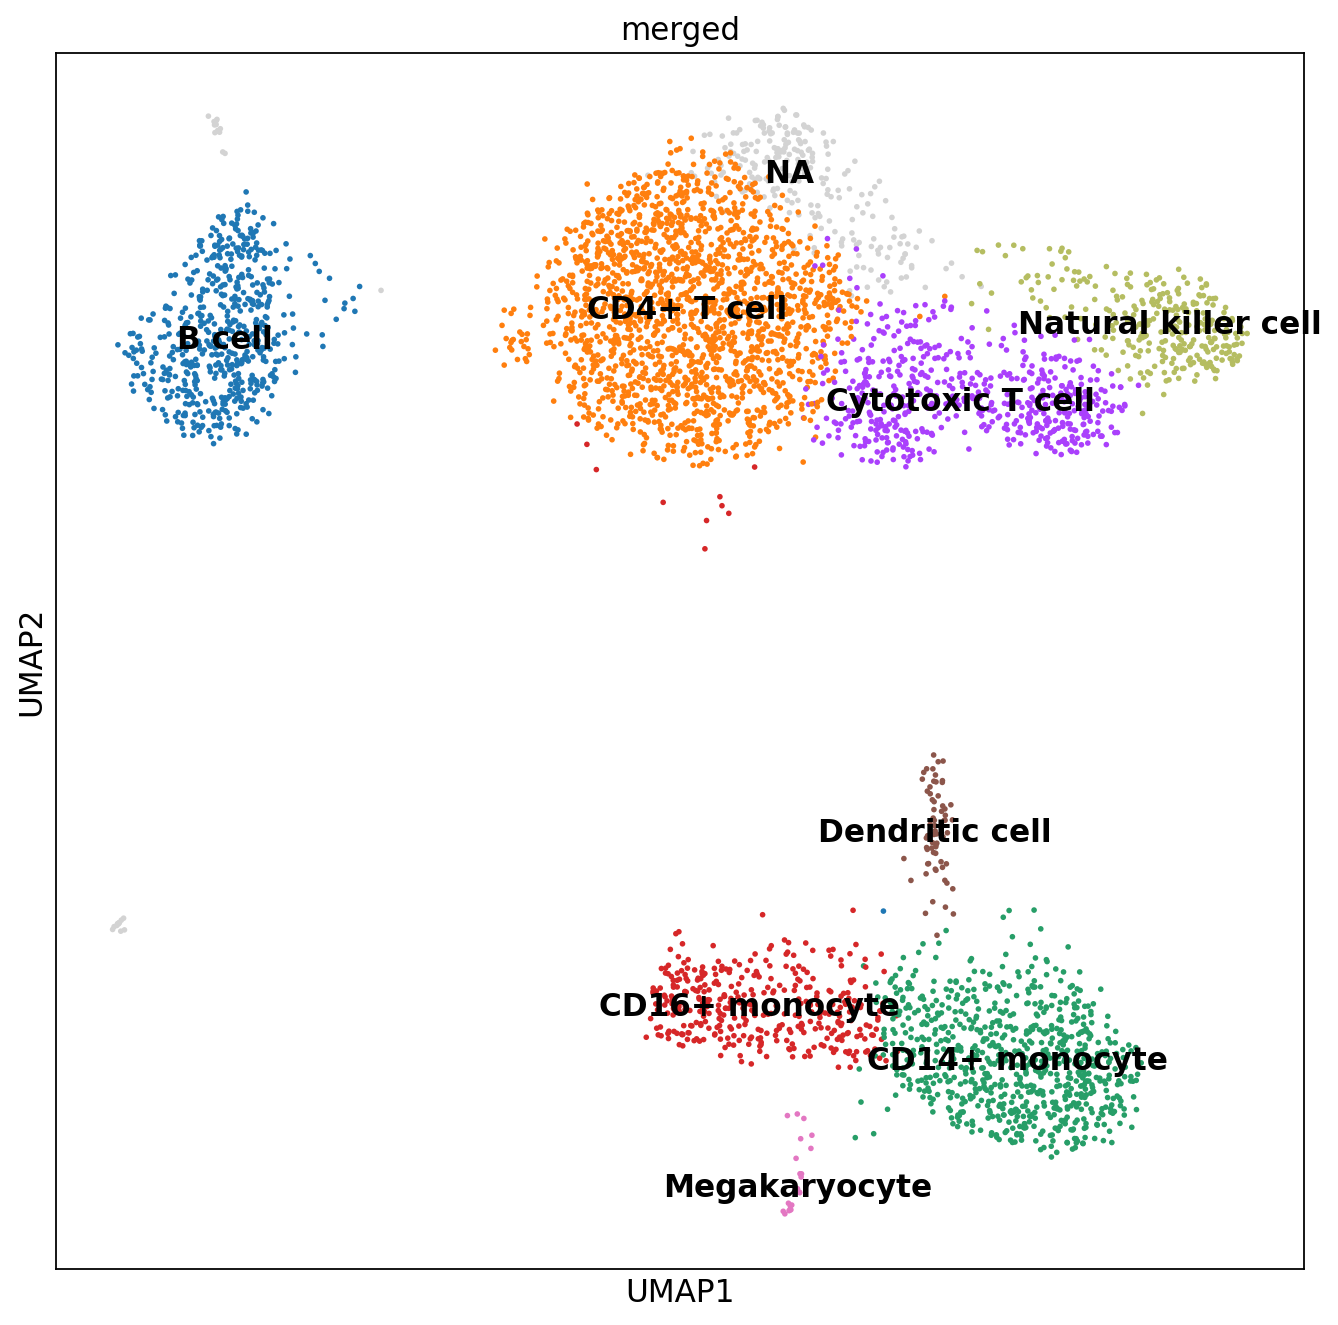

In [174]:
# lets use Leiden clustering
sc.tl.leiden(adata, resolution=0.7)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='merged', legend_loc='on data')

... storing 'merged' as categorical


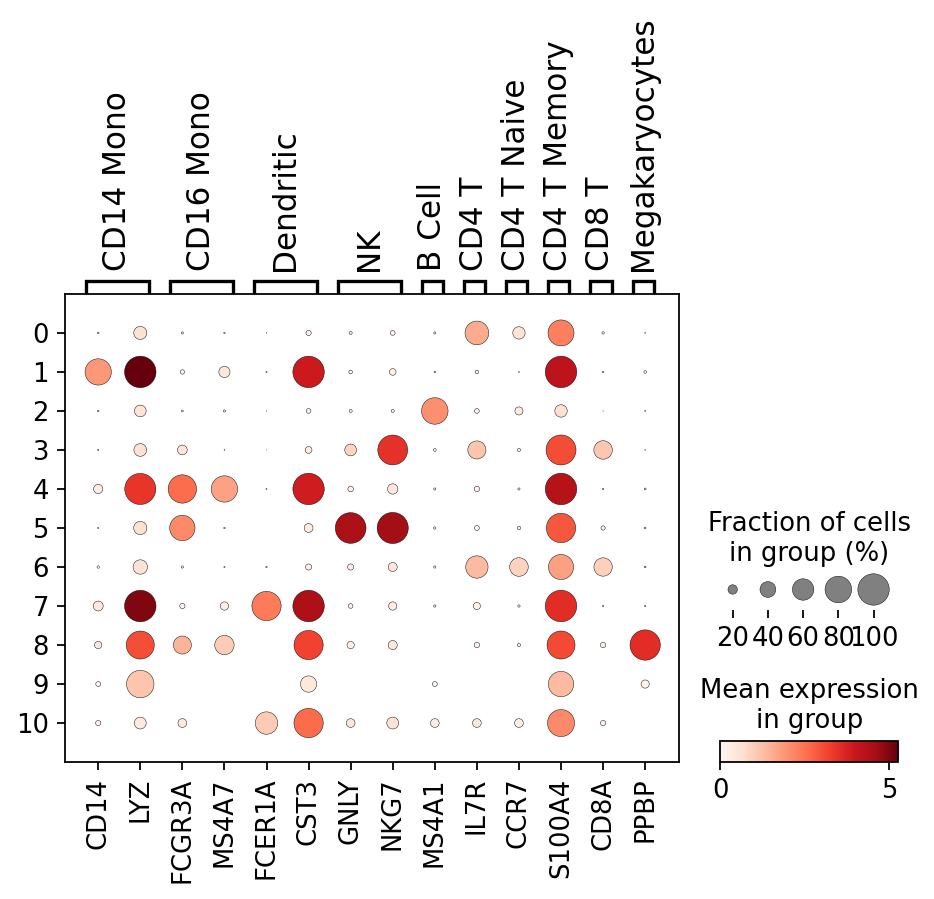

In [171]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', dendrogram=False)


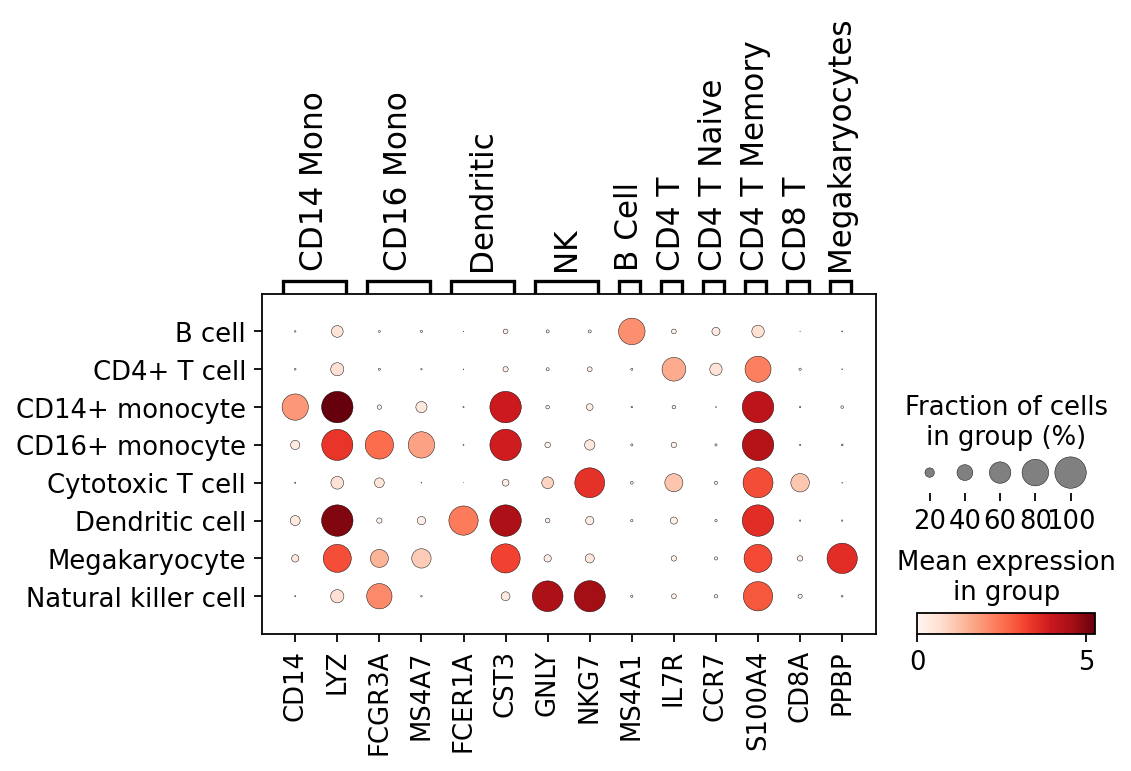

In [172]:
sc.pl.dotplot(adata, marker_genes_dict, groupby='merged', dendrogram=False)


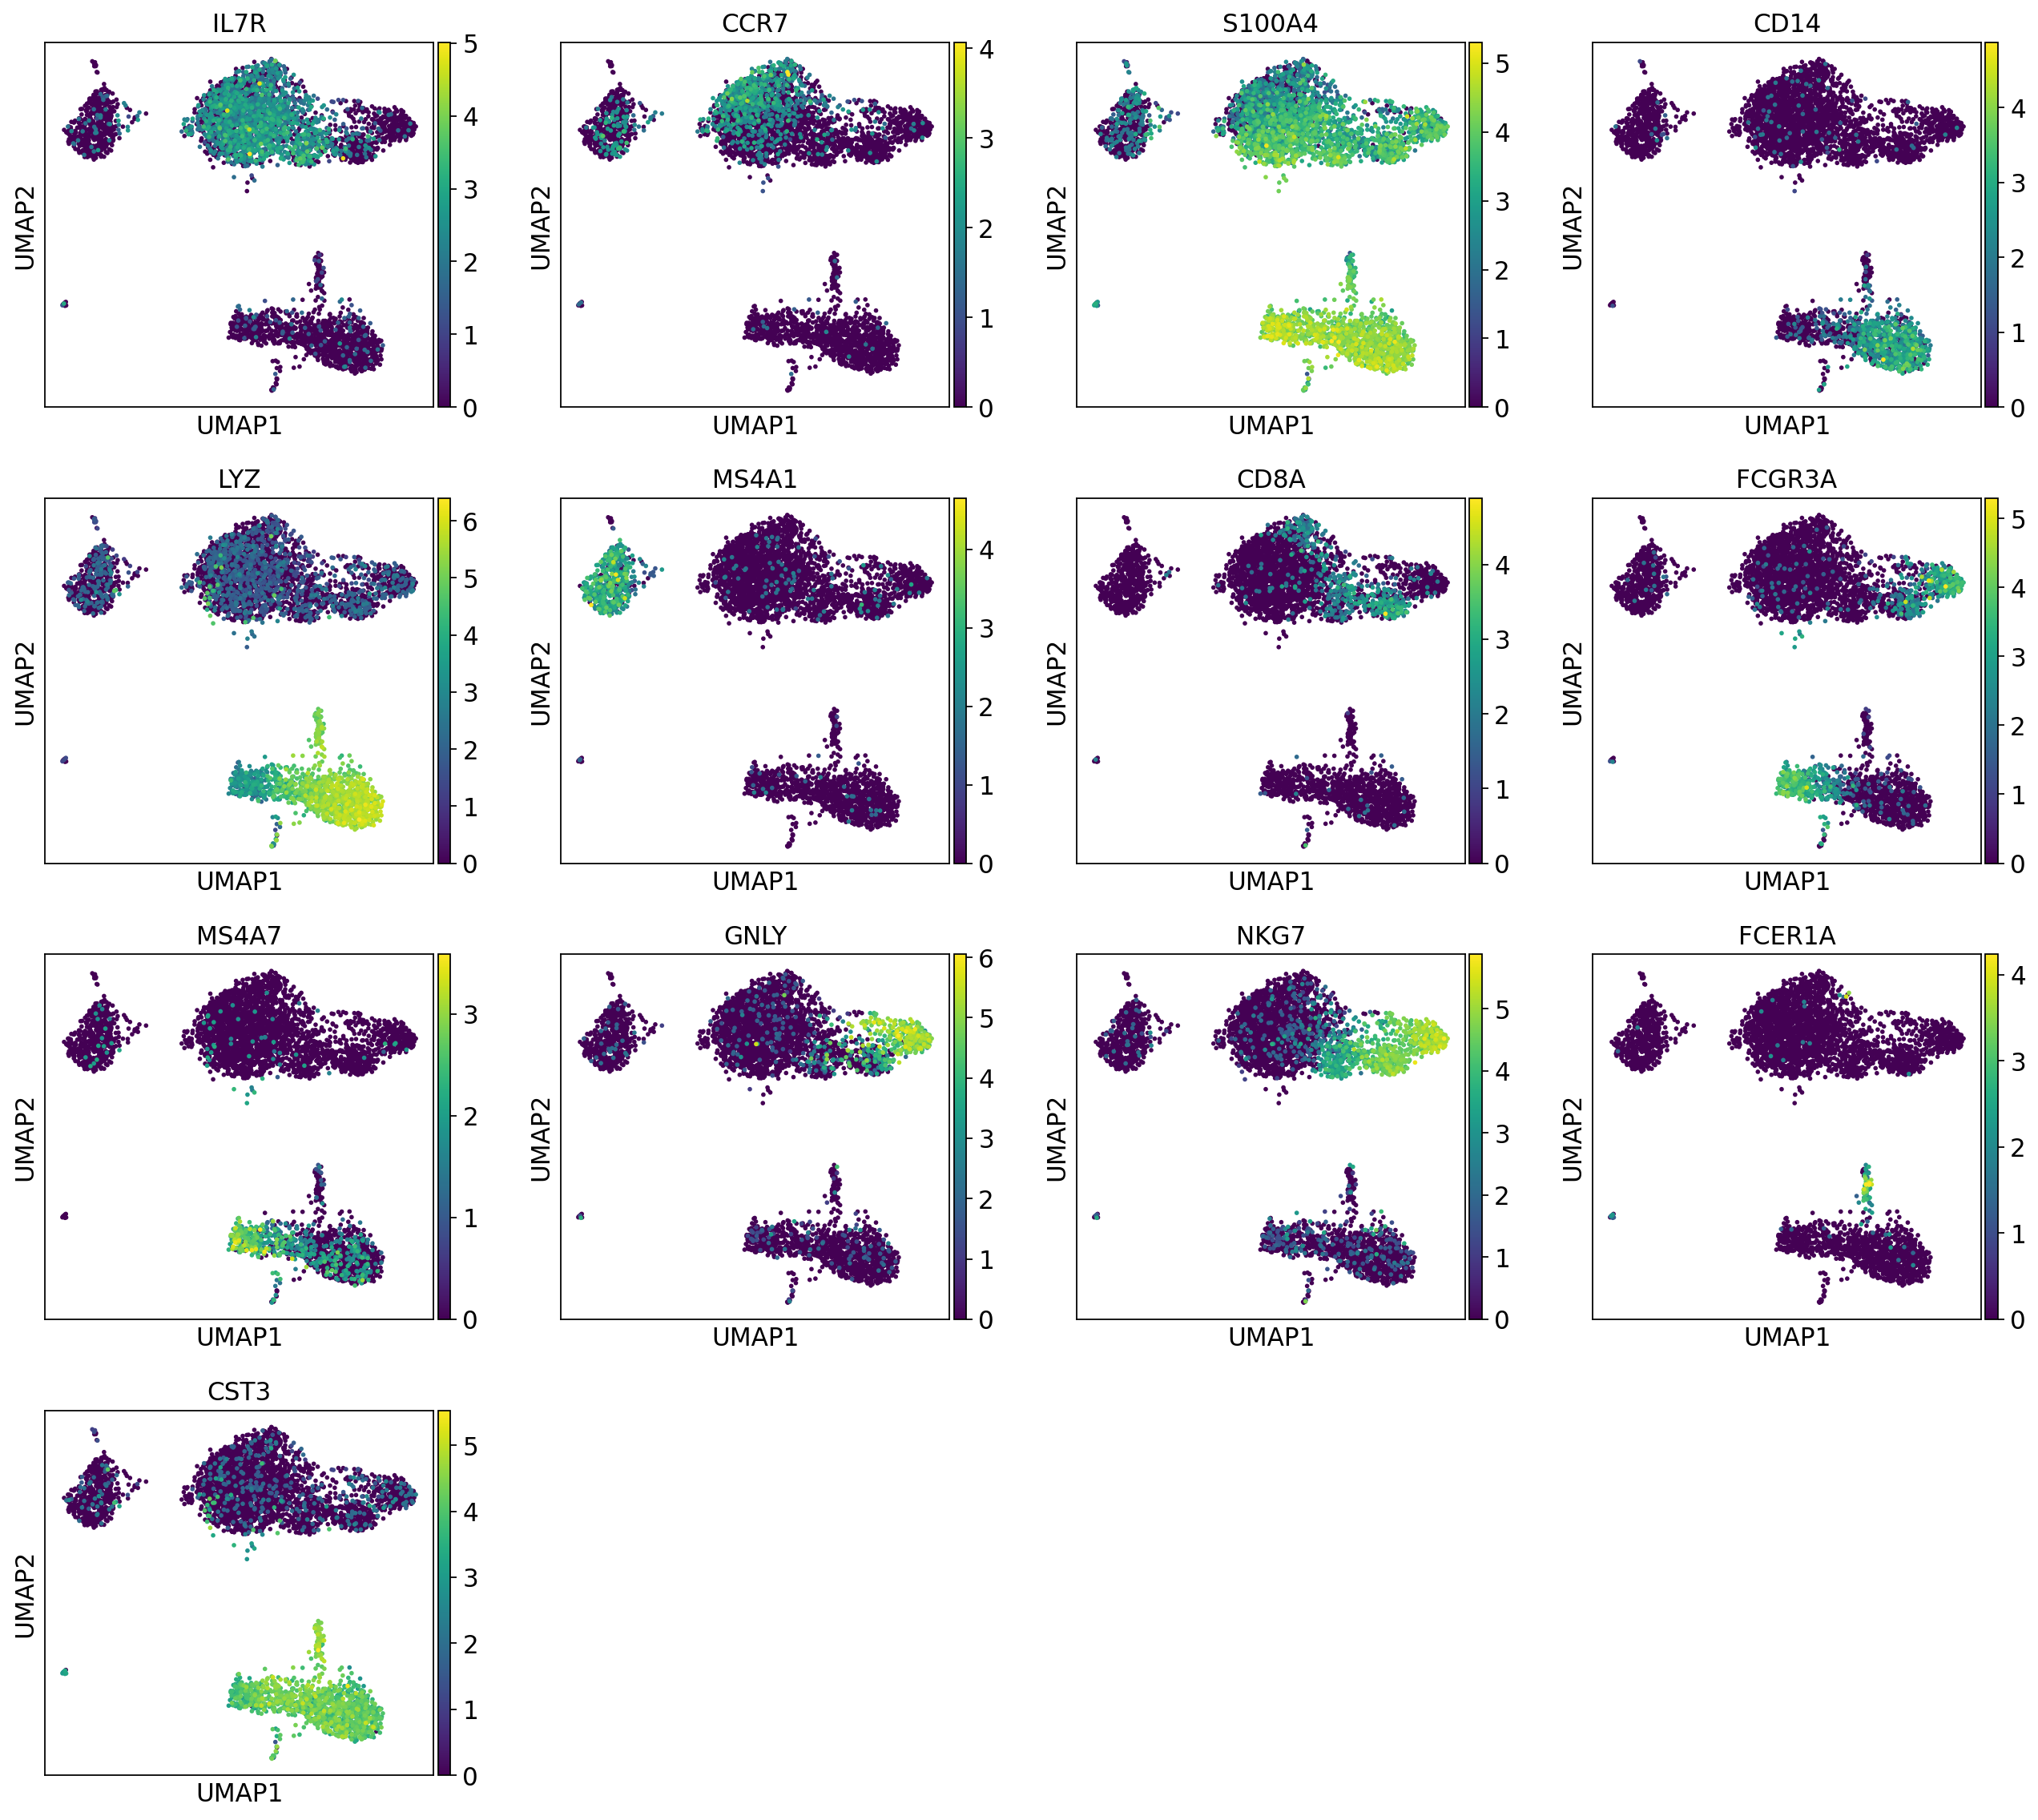

In [161]:
gene_list = ['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A',
    'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3']

sc.pl.umap(adata, color=[i for i in gene_list], color_map='viridis', legend_fontsize=8)

## Find marker genes

ranking genes
    finished (0:00:06)


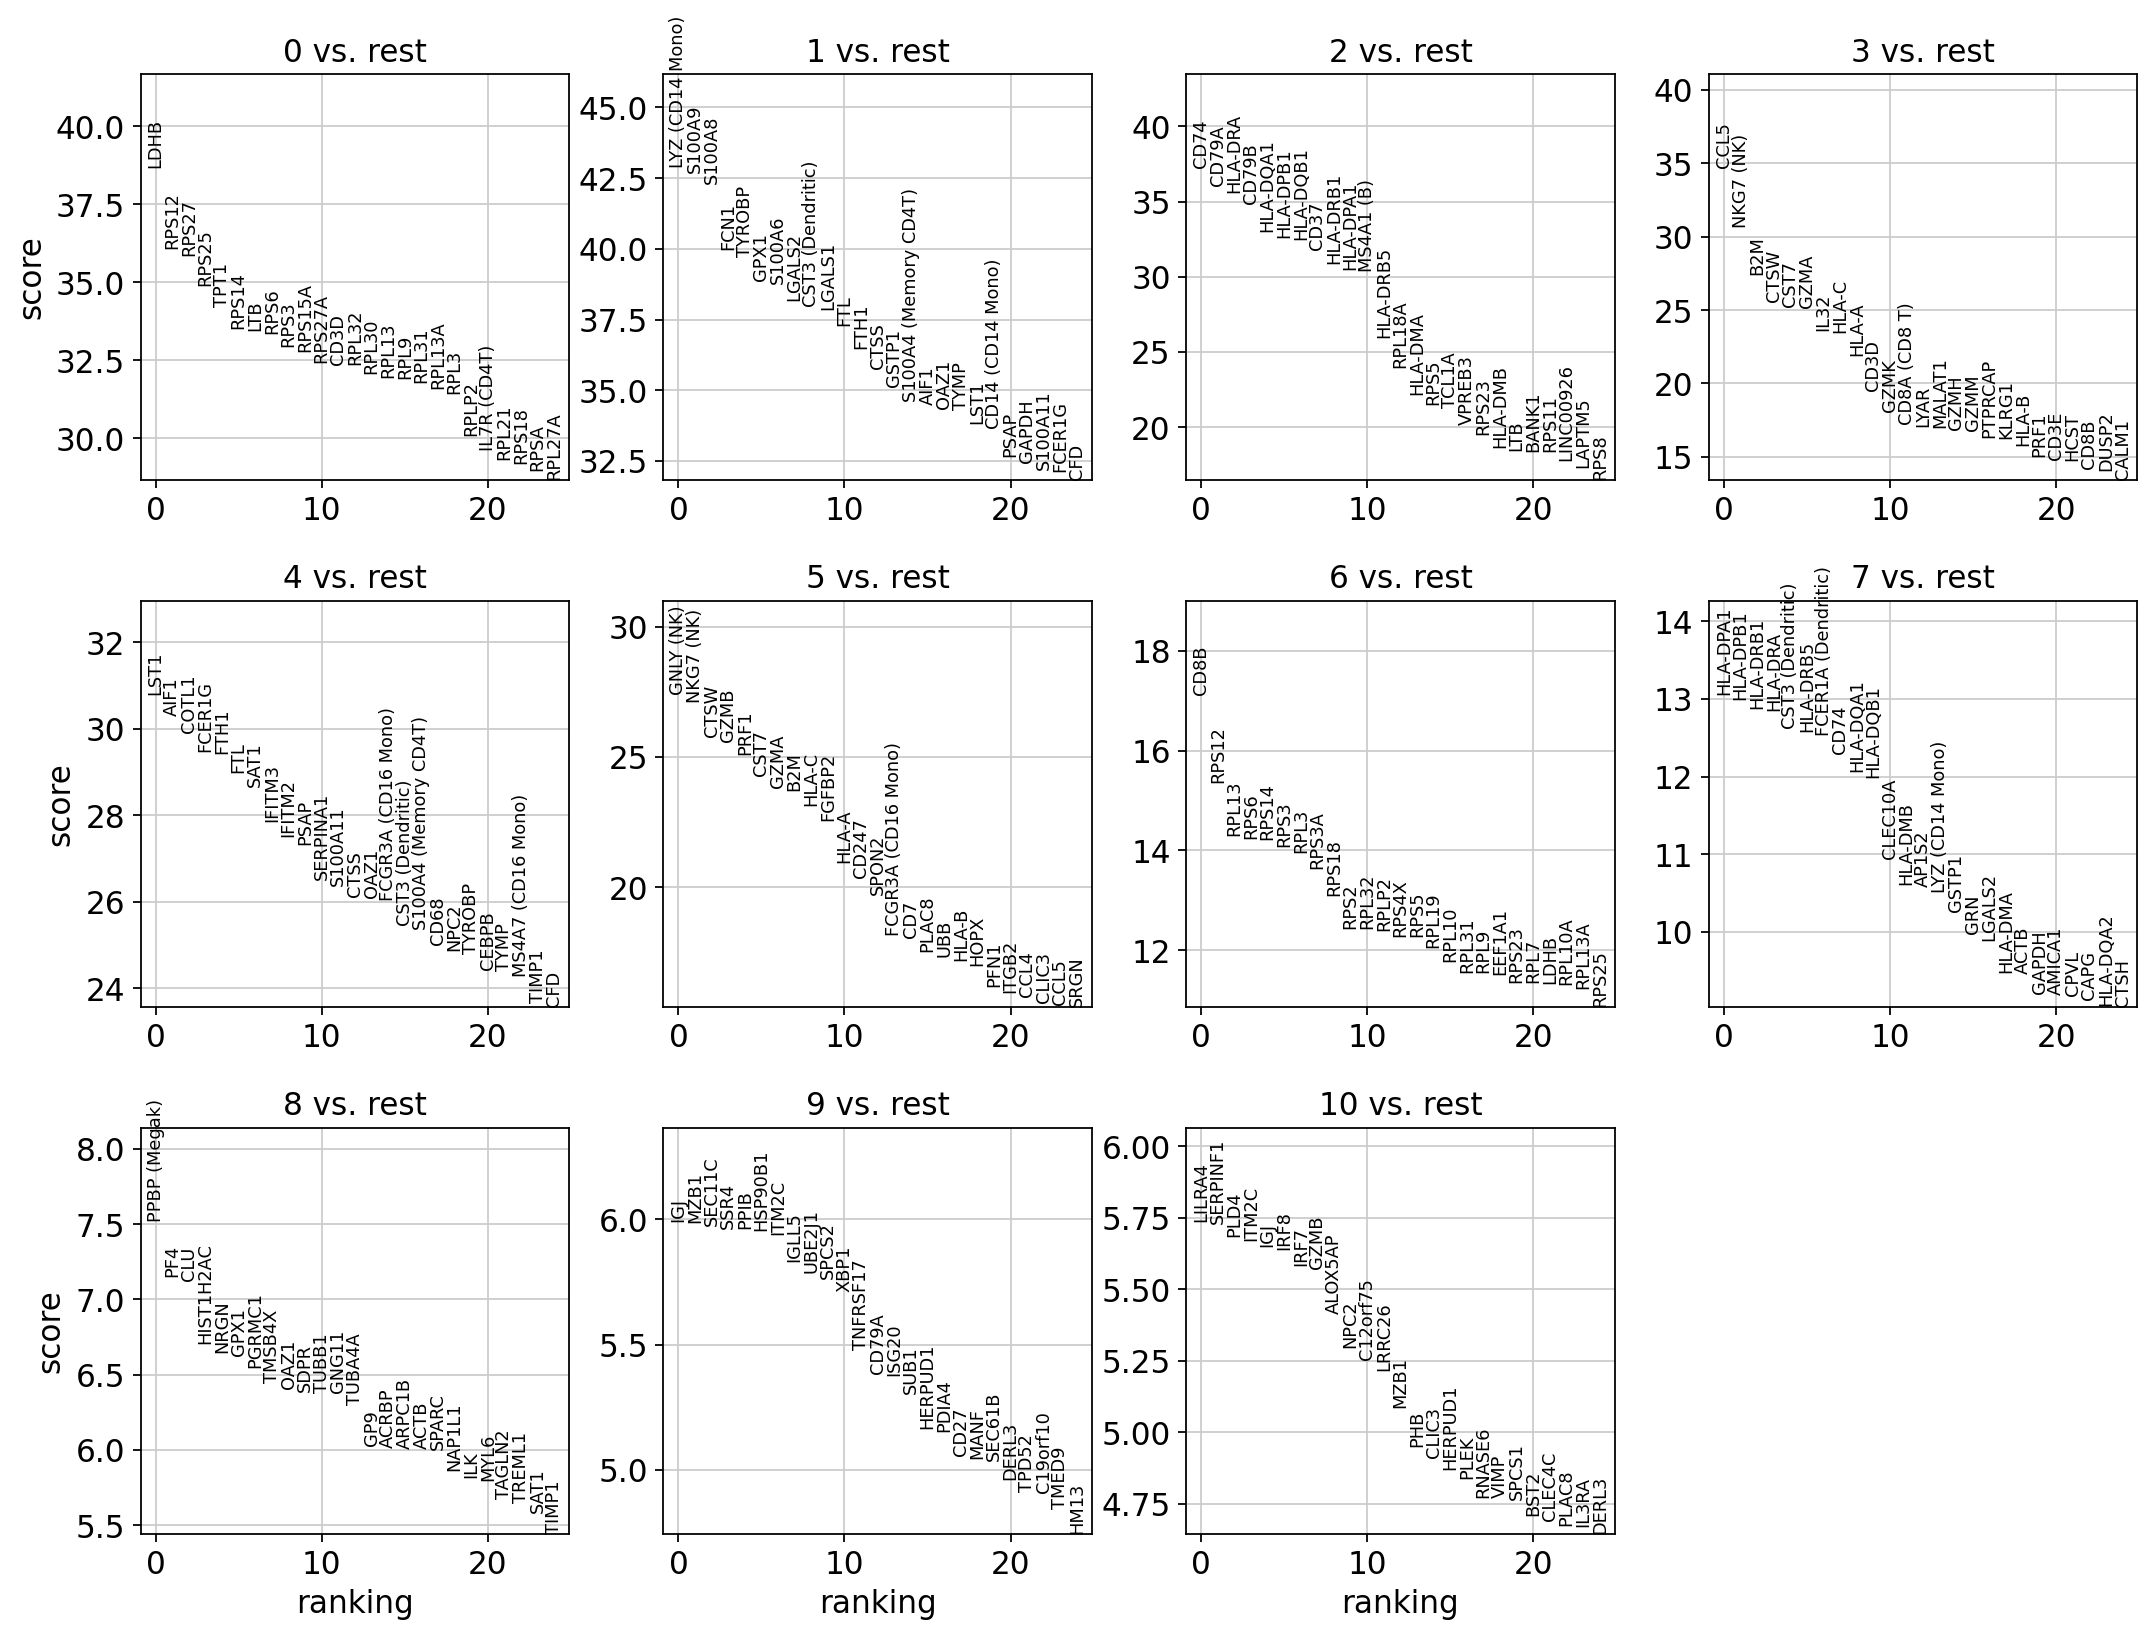

In [162]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)


ranking genes
    finished (0:00:05)


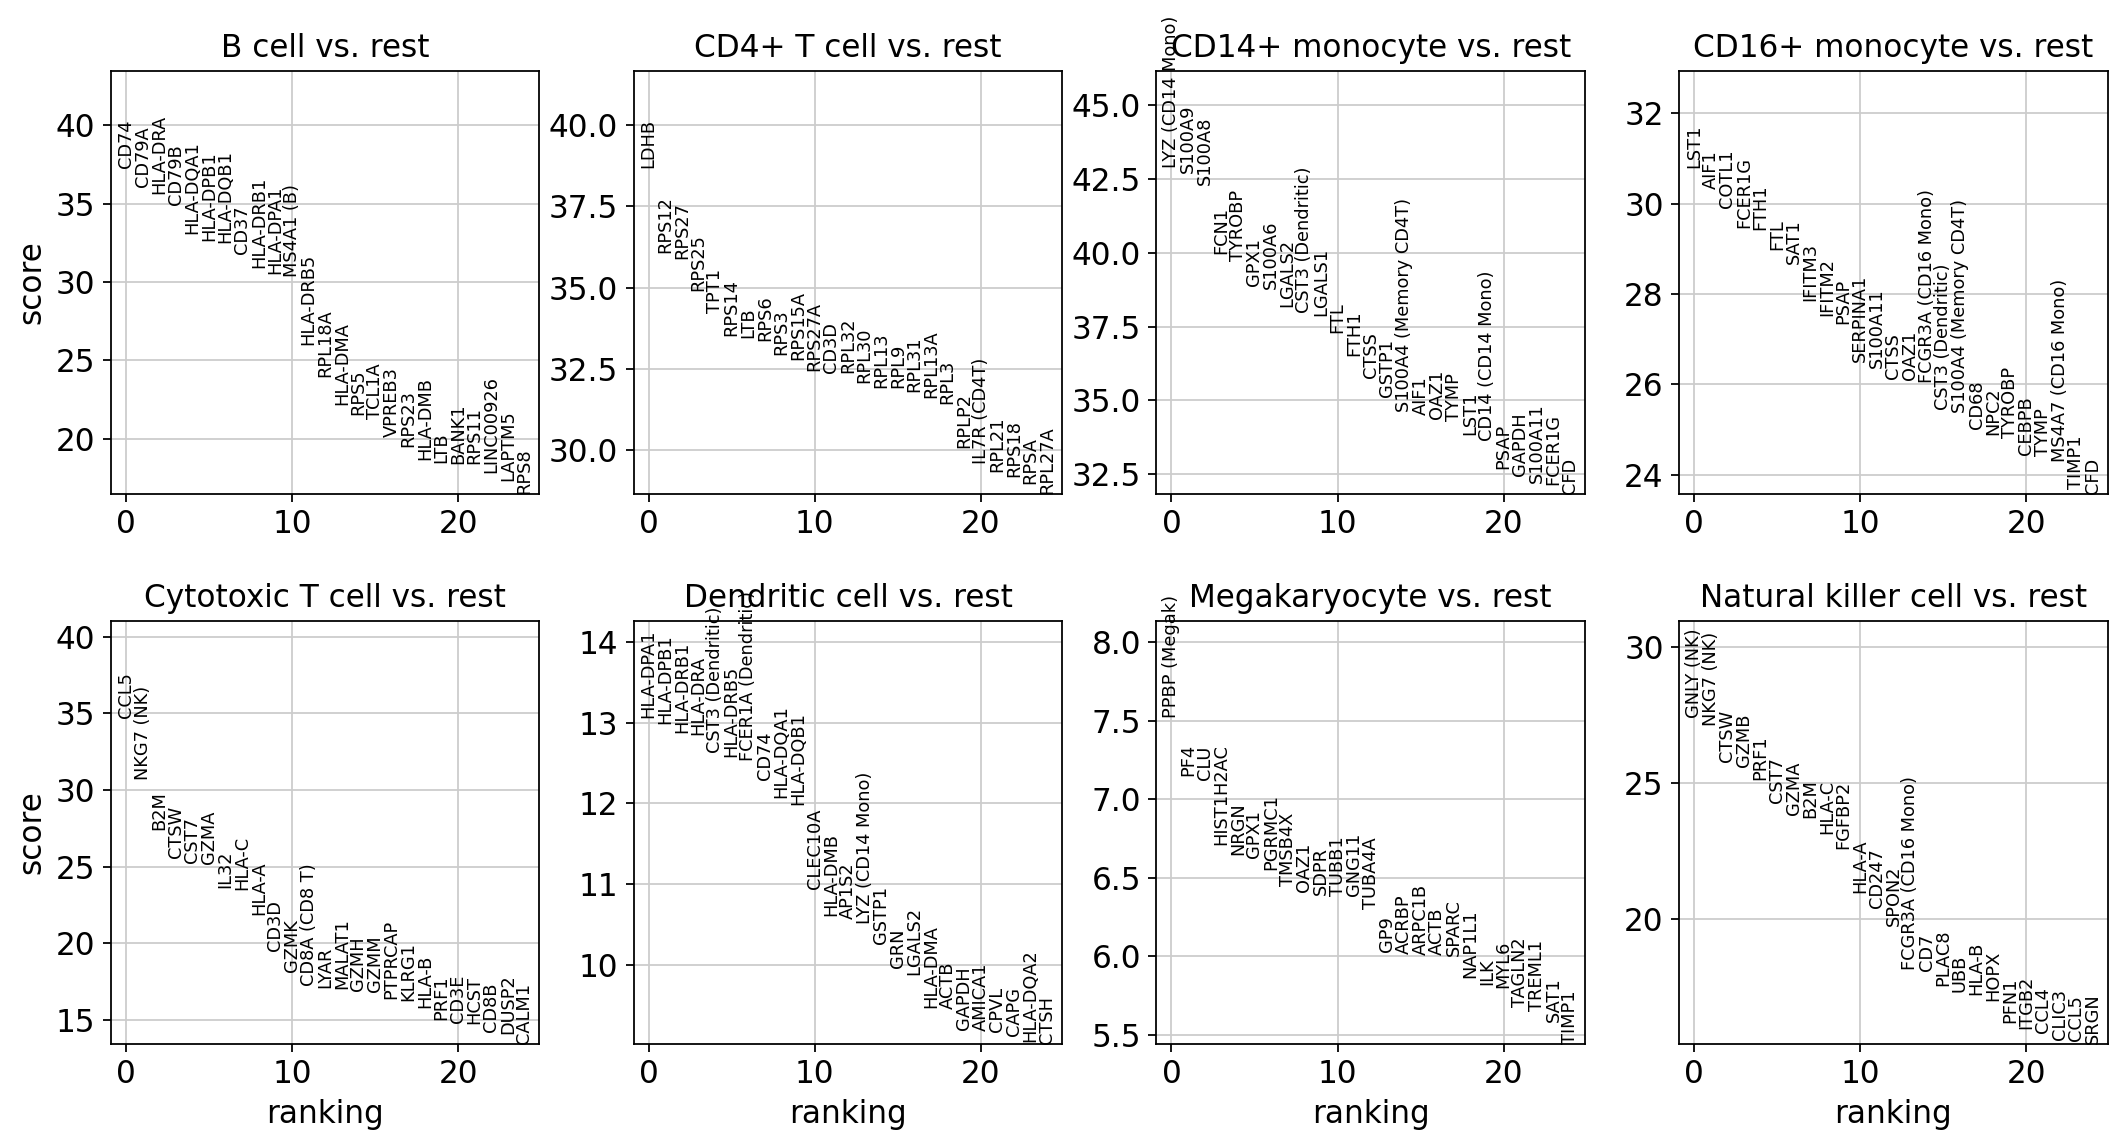

In [173]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'merged', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)

In [163]:
# show top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0       1         2     3       4     5      6         7          8  \
0   LDHB     LYZ      CD74  CCL5    LST1  GNLY   CD8B  HLA-DPA1       PPBP   
1  RPS12  S100A9     CD79A  NKG7    AIF1  NKG7  RPS12  HLA-DPB1        PF4   
2  RPS27  S100A8   HLA-DRA   B2M   COTL1  CTSW  RPL13  HLA-DRB1        CLU   
3  RPS25    FCN1     CD79B  CTSW  FCER1G  GZMB   RPS6   HLA-DRA  HIST1H2AC   
4   TPT1  TYROBP  HLA-DQA1  CST7    FTH1  PRF1  RPS14      CST3       NRGN   

        9        10  
0     IGJ    LILRA4  
1    MZB1  SERPINF1  
2  SEC11C      PLD4  
3    SSR4     ITM2C  
4    PPIB       IGJ

In [164]:
# show p-values
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

0_n            0_p     1_n            1_p       2_n  \
0          LDHB   0.000000e+00     LYZ   0.000000e+00      CD74   
1         RPS12  8.441308e-285  S100A9   0.000000e+00     CD79A   
2         RPS27  1.177867e-281  S100A8   0.000000e+00   HLA-DRA   
3         RPS25  9.618520e-267    FCN1   0.000000e+00     CD79B   
4          TPT1  8.480384e-257  TYROBP   0.000000e+00  HLA-DQA1   
...         ...            ...     ...            ...       ...   
13132  HLA-DRB1  9.762760e-262   RPL21  5.129178e-226      SRGN   
13133  HLA-DPB1  2.179766e-268   RPS27  8.746030e-228     ANXA1   
13134   HLA-DRA  2.644714e-277    RPSA  9.477997e-235    S100A6   
13135      CYBA  3.072997e-282  RPS27A  2.525780e-266    TMSB4X   
13136      CD74   0.000000e+00  MALAT1  1.582332e-297    S100A4   

                 2_p      3_n            3_p     4_n            4_p  ...  \
0      1.313363e-303     CCL5  1.150771e-263    LST1  4.275569e-208  ...   
1      5.270158e-285     NKG7  3.158154e-206    AIF1  6.931593e-202  ...   
2      1.057176e-277      B2M  1.610969e-165   COTL1  1.339072e-196  ...   
3      8.463685e-267     CTSW  2.060512e-144  FCER1G  8.055608e-191  ...   
4      2.612480e-239     CST7  2.798555e-140    FTH1  2.466964e-190  ...   
...              ...      ...            ...     ...            ...  ...   
13132  5.244168e-112    RPS11   1.387963e-41   RPS18  2.960752e-121  ...   
13133  1.009289e-119     AIF1   2.282881e-42   RPL13  5.265629e-126  ...   
13134  1.025482e-137  HLA-DRA   2.020375e-48  RPL13A  1.384720e-129  ...   
13135  1.764391e-169     FTH1   8.164832e-50    RPS3  6.051867e-140  ...   
13136  4.165682e-186   TMSB10   5.170233e-61    RPL3  1.650653e-142  ...   

          6_n           6_p       7_n           7_p        8_n           8_p  \
0        CD8B  1.086144e-65  HLA-DPA1  6.041111e-39       PPBP  5.636044e-14   
1       RPS12  3.461855e-53  HLA-DPB1  1.436049e-38        PF4  8.594052e-13   
2       RPL13  2.203871e-46  HLA-DRB1  6.193619e-38        CLU  1.059633e-12   
3        RPS6  6.274001e-46   HLA-DRA  8.396698e-38  HIST1H2AC  1.950290e-11   
4       RPS14  7.960323e-46      CST3  1.532766e-36       NRGN  3.017692e-11   
...       ...           ...       ...           ...        ...           ...   
13132   CLIC1  2.069673e-25      BTG1  3.928804e-15      RPL7A  3.719213e-07   
13133    FTH1  4.362440e-30     RPL21  1.325216e-15     RPS27A  3.215083e-07   
13134    CD74  4.134338e-30    RPS27A  4.182670e-18       RPS3  2.175531e-07   
13135  S100A4  2.664013e-30       B2M  5.392220e-24      RPS27  1.673419e-07   
13136    CYBA  9.014880e-37    MALAT1  1.239912e-27     RPL13A  1.207167e-07   

          9_n           9_p      10_n          10_p  
0         IGJ  2.087973e-09    LILRA4  9.663716e-09  
1        MZB1  2.135161e-09  SERPINF1  1.005324e-08  
2      SEC11C  2.298068e-09      PLD4  1.313718e-08  
3        SSR4  2.437691e-09     ITM2C  1.413337e-08  
4        PPIB  2.444085e-09       IGJ  1.611870e-08  
...       ...           ...       ...           ...  
13132   RPL30  1.252217e-04    TMSB10  2.827391e-04  
13133    BTG1  1.039345e-04      BTG1  1.262140e-04  
13134    FTH1  9.457718e-05    MT-CYB  1.149649e-04  
13135    ACTB  3.831114e-06      CD52  1.620512e-05  
13136  TMSB4X  6.371667e-09    TMSB4X  3.886516e-06  

[13137 rows x 22 columns]

In [165]:
result['names']['0']

array(['LDHB', 'RPS12', 'RPS27', ..., 'HLA-DRA', 'CYBA', 'CD74'],
      dtype=object)

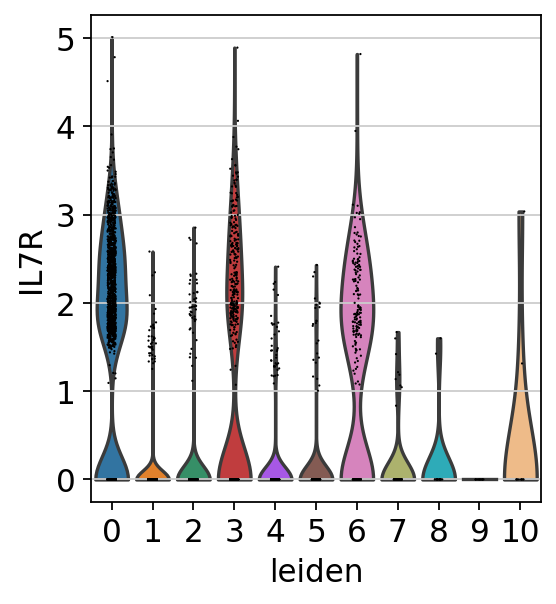

In [166]:
# show expression of some marker genes by group
sc.pl.violin(adata, ['IL7R'], groupby='leiden')


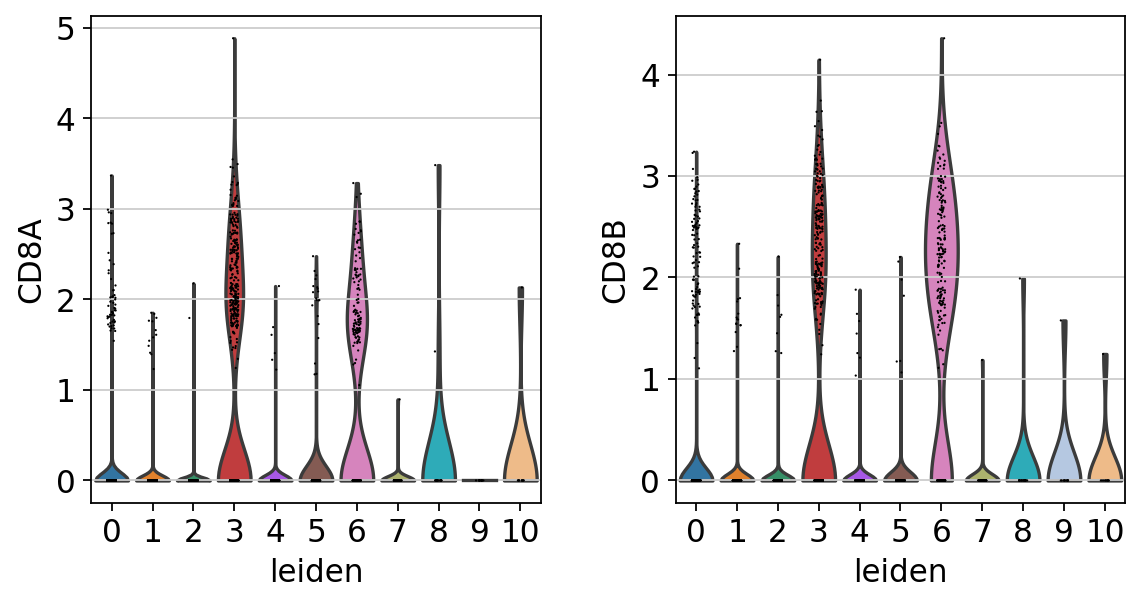

In [167]:
sc.pl.violin(adata, ['CD8A', 'CD8B'], groupby='leiden')


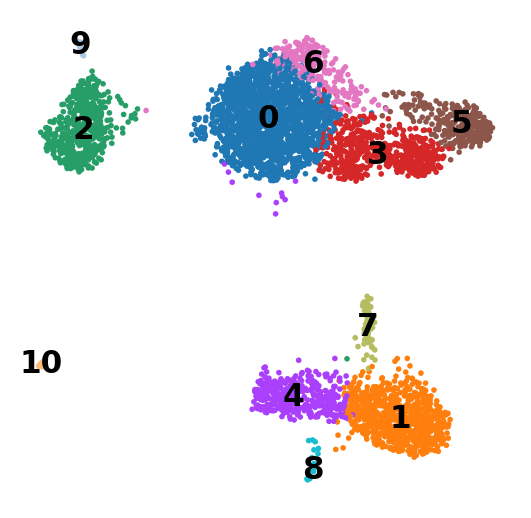

In [168]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', )


In [169]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
